# Function Regression Example

* Import packages:

In [1]:
import sys
print("The Python version is %s.%s.%s" % sys.version_info[:3])
import torch
print(f'The Torch version is: {torch.__version__}')
from torch import nn
import matplotlib.pyplot as plt
from torch import optim
from torch.autograd import grad
import numpy as np

The Python version is 3.7.0
The Torch version is: 1.0.1.post2


* We can inspect the package torch

In [90]:
?torch

Type:        module
String form: <module 'torch' from '/Users/landajuelala1/Applications/brew/lib/python3.7/site-packages/torch/__init__.py'>
File:        ~/Applications/brew/lib/python3.7/site-packages/torch/__init__.py
Docstring:  
The torch package contains data structures for multi-dimensional
tensors and mathematical operations over these are defined.
Additionally, it provides many utilities for efficient serializing of
Tensors and arbitrary types, and other useful utilities.

It has a CUDA counterpart, that enables you to run your tensor computations
on an NVIDIA GPU with compute capability >= 3.0.


* The function to approximate is :

In [2]:
def f1(x):
    "f1 function"
    ret = 1 - 1.5*torch.sin(x) + 0.5*torch.sin(x*x) + torch.tanh(x*x*x)
    return ret

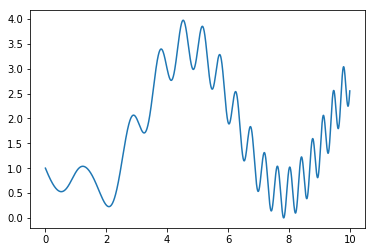

In [3]:
dx = 0.001
X = torch.arange(0.0, 10.0, dx)
y = f1(X)
plt.plot(X.numpy(),y.numpy(),"-", label="f1")

* Split train and validation sets:

In [7]:
import random
split_amount = 0.8
data_length = X.shape[0]
train_length = int(split_amount*data_length)
index_list = list(range(data_length))
random.shuffle(index_list)
index_train = index_list[:train_length]
index_val = index_list[train_length:]

X_train = X[index_train]
X_val = X[index_val]
y_train = y[index_train]
y_val = y[index_val]

* Plot the train and validation examples:

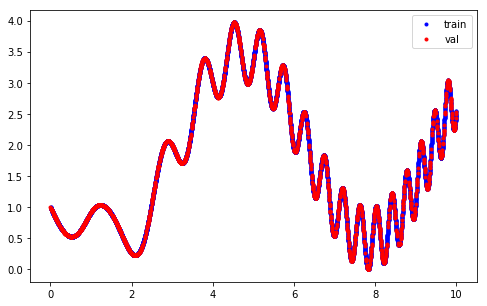

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(X_train.numpy(),y_train.numpy(),"b.", label="train")
plt.plot(X_val.numpy(),y_val.numpy(),"r.", label="val")
plt.legend()

* Transform the numpy.ndarray to torch.Tensor and reshape the y tensor

In [53]:
X_train = X_train.view(X_train.shape[0],-1)
X_val = X_val.view(X_val.shape[0],-1)
y_train = y_train.view(y_train.shape[0],-1)
y_val = y_val.view(y_val.shape[0],-1)
print(f'X_train is of type {type(X_train)} and X_train.shape = {X_train.shape}')
print(f'y_train is of type {type(y_train)} and y_train.shape = {y_train.shape}')
print(f'X_val is of type {type(X_val)} and X_val.shape = {X_val.shape}')
print(f'y_val is of type {type(y_val)} and y_val.shape = {y_val.shape}')

X_train is of type <class 'torch.Tensor'> and X_train.shape = torch.Size([8000, 1])
y_train is of type <class 'torch.Tensor'> and y_train.shape = torch.Size([8000, 1])
X_val is of type <class 'torch.Tensor'> and X_val.shape = torch.Size([2000, 1])
y_val is of type <class 'torch.Tensor'> and y_val.shape = torch.Size([2000, 1])


* Non-linear net:

In [73]:
class Net(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.h1 = nn.Linear(input_dim, hidden_dim)
        self.h2 = nn.Linear(hidden_dim, hidden_dim)
        self.h3 = nn.Linear(hidden_dim, hidden_dim)
        self.h4 = nn.Linear(hidden_dim, 1)
    def forward(self, X):
        X = self.h1(X)
        X = torch.tanh(X)
        X = self.h2(X)
        X = torch.tanh(X)
        X = self.h3(X)
        X = torch.tanh(X)
        X = self.h4(X)
        return X

* Initialization :

In [74]:
n_features = 1
hidden_dim = 20
learning_rate = 0.01
schedulerPlateau = True

model = Net(n_features,hidden_dim)
  
for idx, m in enumerate(model.modules()):         
    if idx > 0:
        print('{} -> {}'.format(idx,m))    
        for name, param in m.named_parameters():
            print('Parameter tensor name : {}, size : {},'.format(name, param.size()), end='\n', flush=True)
            print('\t Initial param.data[0] : {}, param.grad : {}'.format(param.data[0], param.grad), end='\n', flush=True)
            print('\t Initialization of {}'.format(name), end="", flush=True)
            if 'weight' in name:   
                torch.nn.init.xavier_uniform_(param.data)
                print('...done')
            elif 'bias' in name:
                param.data.fill_(0)
                print('...done')
            print('\t Final param.data[0] : {}, param.grad : {}'.format(param.data[0], param.grad), end='\n', flush=True)    
        print('')   
        
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr = learning_rate)

if not schedulerPlateau:
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 1, gamma = 1.0)
else:    
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose = True, patience = 200)

1 -> Linear(in_features=1, out_features=20, bias=True)
Parameter tensor name : weight, size : torch.Size([20, 1]),
	 Initial param.data[0] : tensor([-0.8714]), param.grad : None
	 Initialization of weight...done
	 Final param.data[0] : tensor([0.3338]), param.grad : None
Parameter tensor name : bias, size : torch.Size([20]),
	 Initial param.data[0] : 0.0944892168045044, param.grad : None
	 Initialization of bias...done
	 Final param.data[0] : 0.0, param.grad : None

2 -> Linear(in_features=20, out_features=20, bias=True)
Parameter tensor name : weight, size : torch.Size([20, 20]),
	 Initial param.data[0] : tensor([-0.0813, -0.1306,  0.0137,  0.0922,  0.1503, -0.1668, -0.1438, -0.0028,
         0.1485,  0.0764,  0.2223, -0.1694, -0.0474,  0.1685, -0.2016, -0.0148,
        -0.1056,  0.0765,  0.1311, -0.1359]), param.grad : None
	 Initialization of weight...done
	 Final param.data[0] : tensor([-0.2487,  0.0184,  0.2700,  0.1028, -0.3232,  0.2282,  0.0560,  0.0288,
        -0.2967,  0.1325

* Training :

In [75]:
epochList = []
lossList = []
lossValList = []
lrList = []
gradnpyInitialize = False
gradList = []
verbose = False
num_epochs = 100000
grad_clipping = False
checkpoint_rate = 100
loss_val = torch.tensor([100.0])

for i in range(num_epochs):
  
    ### SCHEDULER ###
    if not schedulerPlateau:
        scheduler.step()
    else:
        scheduler.step(loss_val)
    if verbose :
        print('\nRight after : scheduler.step()')
        print(f'Loss : {loss.item():0.1f}')
        for param_group in optimizer.param_groups:
            print('Learning rate: {}'.format(param_group['lr']))
    
    # Model in training mode:
    model.train()
    if verbose :
        print('\nModel in train mode')
    
    ### ZEROED THE GRADIENTS ###
    optimizer.zero_grad()
    if verbose :
        print('Right after : optimizer.zero_grad()')
        for param in model.parameters():
            print('param.data : {}, param.grad : {}'.format(param.data, param.grad))

    ### FORWARD PROP ###        
    y_ = model(X_train)
    if verbose :
        print("y_.requires_grad : {}".format(y_.requires_grad))

    ### LOSS ###
    loss = criterion(y_, y_train)
    
    ### BACKWARD PROP ###
    loss.backward()
    if verbose :
        print('Right after : loss.backward()')
        for param in model.parameters():
            print('param.data : {}, param.grad : {}'.format(param.data, param.grad))
    
    if grad_clipping :
        ### CLIPPING ###
        torch.nn.utils.clip_grad_norm_(model.parameters(),1, norm_type=2)
        if verbose :
            print('Right after : clip_grad_norm_')
            for param in model.parameters():
                print('param.data : {}, param.grad : {}'.format(param.data, param.grad))  

    ### ADVANCE THE PARAMETERS OVER THE HILL ###
    optimizer.step()
    if verbose :
        print('Right after : optimizer.step()')
        for param in model.parameters():
            print('param.data : {}, param.grad : {}'.format(param.data, param.grad))       

    if i % checkpoint_rate == 0 :        
   
        ### EVALUATION ###  
        model.eval()
    
        if verbose :
            print('\nModel in eval mode')
            
        with torch.no_grad():
            y_ = model(X_val)
            if verbose :
                print("y_.requires_grad : {}".format(y_.requires_grad))    
            loss_val = criterion(y_, y_val)
                 
        gradList = []  
        for p in list(filter(lambda p: p.grad is not None, model.parameters())):
            gradList.append(p.grad.data.norm(2).item())
    
        if not gradnpyInitialize :
            gradnpy = np.asarray(gradList).reshape((1, len(gradList)))
            gradnpyInitialize = True              
        else :
            gradnpy = np.concatenate((gradnpy, np.asarray(gradList).reshape((1, len(gradList)))), axis=0)
    
        if not verbose:
            print(f'Epoch : {i}, Train Loss : {loss.item()}, Val Loss : {loss_val.item()}')
        
        epochList.append(i)
        lossList.append(loss.item())
        lossValList.append(loss_val.item())
        for param_group in optimizer.param_groups:
            lrList.append(param_group['lr'])

Epoch : 0, Train Loss : 5.728947639465332, Val Loss : 2.0662484169006348
Epoch : 100, Train Loss : 0.33205506205558777, Val Loss : 0.3500801920890808
Epoch : 200, Train Loss : 0.13453249633312225, Val Loss : 0.13284453749656677
Epoch : 300, Train Loss : 0.11185511946678162, Val Loss : 0.11763522773981094
Epoch : 400, Train Loss : 0.10708887130022049, Val Loss : 0.10657770931720734
Epoch : 500, Train Loss : 0.10432901978492737, Val Loss : 0.10428128391504288
Epoch : 600, Train Loss : 0.1015906110405922, Val Loss : 0.10192693769931793
Epoch : 700, Train Loss : 0.09934794157743454, Val Loss : 0.09983742982149124
Epoch : 800, Train Loss : 0.09737665951251984, Val Loss : 0.09803739935159683
Epoch : 900, Train Loss : 0.0959804579615593, Val Loss : 0.09671716392040253
Epoch : 1000, Train Loss : 0.09463076293468475, Val Loss : 0.09555768221616745
Epoch : 1100, Train Loss : 0.09330446273088455, Val Loss : 0.09437555074691772
Epoch : 1200, Train Loss : 0.09204721450805664, Val Loss : 0.093094214

* Post-processing:

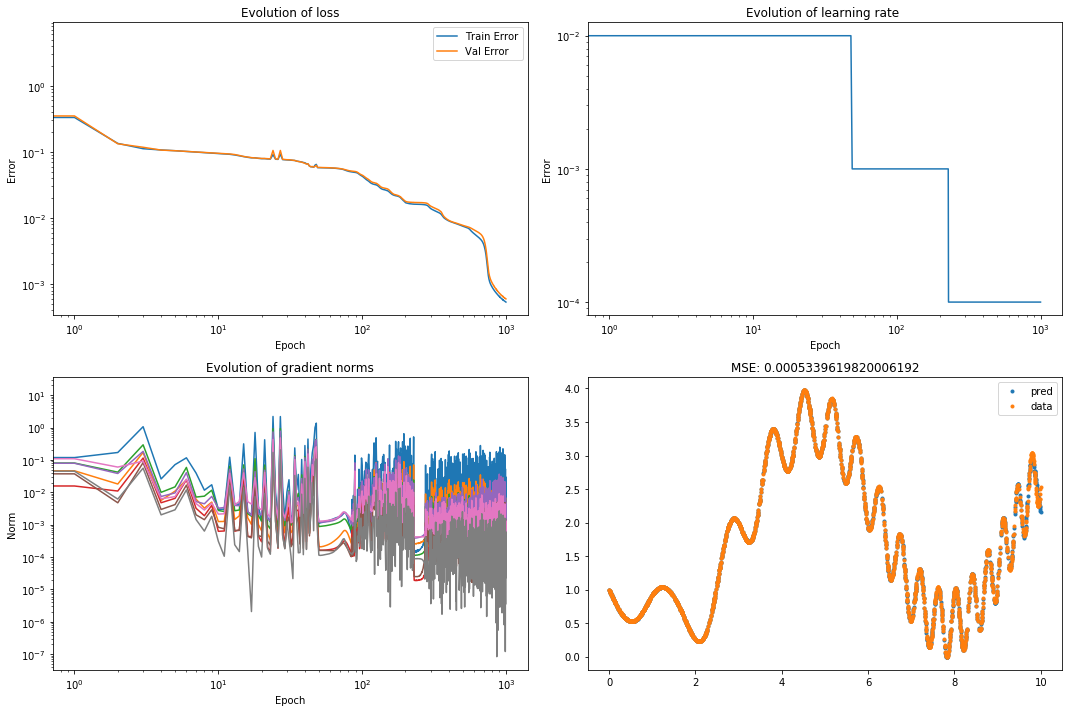

In [77]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.loglog(lossList, label='Train Error')
plt.loglog(lossValList, label='Val Error')
plt.title('Evolution of loss')
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2, 2, 2)
plt.loglog(lrList)
plt.title('Evolution of learning rate ')
plt.ylabel('Error')
plt.xlabel('Epoch')

plt.subplot(2, 2, 3)
plt.loglog(gradnpy)
plt.title('Evolution of gradient norms')
plt.ylabel('Norm')
plt.xlabel('Epoch')

# Visualization
with torch.no_grad():
    y_ = model(X_val)
    plt.subplot(2, 2, 4)
    plt.plot(X_val.numpy(), y_.detach().numpy(), ".", label="pred")
    plt.plot(X_val.numpy(), y_val.numpy(), ".", label="data")
    plt.title(f"MSE: {loss.item()}")
    plt.legend()

plt.tight_layout()
plt.show() 